# Holo1.5: Cookbook

[![Colab](https://img.shields.io/badge/Open_in_Colab-F9AB00?logo=googlecolab&logoColor=fff&style=for-the-badge)](https://colab.research.google.com/github/hcompai/hai-cookbook/blob/main/holo1_5/holo_1_5_quickstart.ipynb)
[![GitHub](https://img.shields.io/badge/Holo_Cookbooks-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/hcompai/hai-cookbook)
[![Hugging Face](https://img.shields.io/badge/H_Company-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/Hcompany)

Holo1.5 is a **state-of-the-art Action Vision-Language Model** developed by [H Company](https://www.hcompany.ai/), achieving 10%+ accuracy improvements over [Holo1](https://huggingface.co/blog/Hcompany/holo1). Fine-tuned from [Qwen/Qwen2.5-VL-7B-Instruct](https://huggingface.co/Qwen/Qwen2.5-VL-7B-Instruct), it excels at **UI element localization** - the critical skill that enables Computer Use agents to navigate digital interfaces like humans do.

## What is UI Element Localization?

UI localization (also called grounding) is how AI agents interact with software through the same visual interface humans use. Given a screenshot and a task like *"Book a hotel in Paris"*, the model identifies exactly where to click by outputting precise pixel coordinates.

This quickstart demonstrates the core grounding capability: **(screenshot + task) → click coordinates**.

## Setup

First, let's import the required dependencies. This cookbook was tested on Python>=3.11.

In [ ]:
!pip install -q -U accelerate matplotlib pillow pydantic requests torchvision transformers>=4.54.0,<4.57.0

In [1]:
from typing import Any, Literal, TypeAlias

import requests
import torch
from PIL import Image
from pydantic import BaseModel, Field
from transformers import AutoModelForImageTextToText, AutoProcessor
from transformers.models.qwen2_vl.image_processing_qwen2_vl import smart_resize

## 1. Load model and processor

Our Holo1.5 family of VLMs includes three model sizes to cover hardware requirements for deployment: 3B, 7B, and 72B. All checkpoints are SOTA with respect to model size.

Model cards for the Holo1.5 family:

[![Hugging Face](https://img.shields.io/badge/Holo_1.5_3B-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/Hcompany/Holo1.5-3B)
[![Hugging Face](https://img.shields.io/badge/Holo_1.5_7B-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/Hcompany/Holo1.5-7B)
[![Hugging Face](https://img.shields.io/badge/Holo_1.5_72B-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/Hcompany/Holo1.5-72B)

In [ ]:
model_name = "Hcompany/Holo1.5-3B"  # or "Hcompany/Holo1.5-7B", "Hcompany/Holo1.5-72B"

# Load model and processor
model = AutoModelForImageTextToText.from_pretrained(
    model_name,
    dtype=torch.bfloat16,
    device_map="auto",
)
processor = AutoProcessor.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

## 2. Define Actions and System Prompt

## How It Works

The model uses structured output to return precise navigation actions. In the cookbook, we only demonstrate the localization capability of our model for simplicity.

In [3]:
class ClickAbsoluteAction(BaseModel):
    """Click at absolute coordinates."""

    action: Literal["click_absolute"] = "click_absolute"
    x: int = Field(description="The x coordinate, number of pixels from the left edge.")
    y: int = Field(description="The y coordinate, number of pixels from the top edge.")


ChatMessage: TypeAlias = dict[str, Any]


def get_chat_messages(task: str, image: Image.Image) -> list[ChatMessage]:
    """Create the prompt structure for navigation task"""
    prompt = f"""Localize an element on the GUI image according to the provided target and output a click position.
     * You must output a valid JSON following the format: {ClickAbsoluteAction.model_json_schema()}
     Your target is:"""

    return [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": f"{prompt}\n{task}"},
            ],
        },
    ]

Now let's download a sample screenshot and define our navigation task.

## 3. Download Image

Task: Book a hotel in Paris on August 3rd for 3 nights


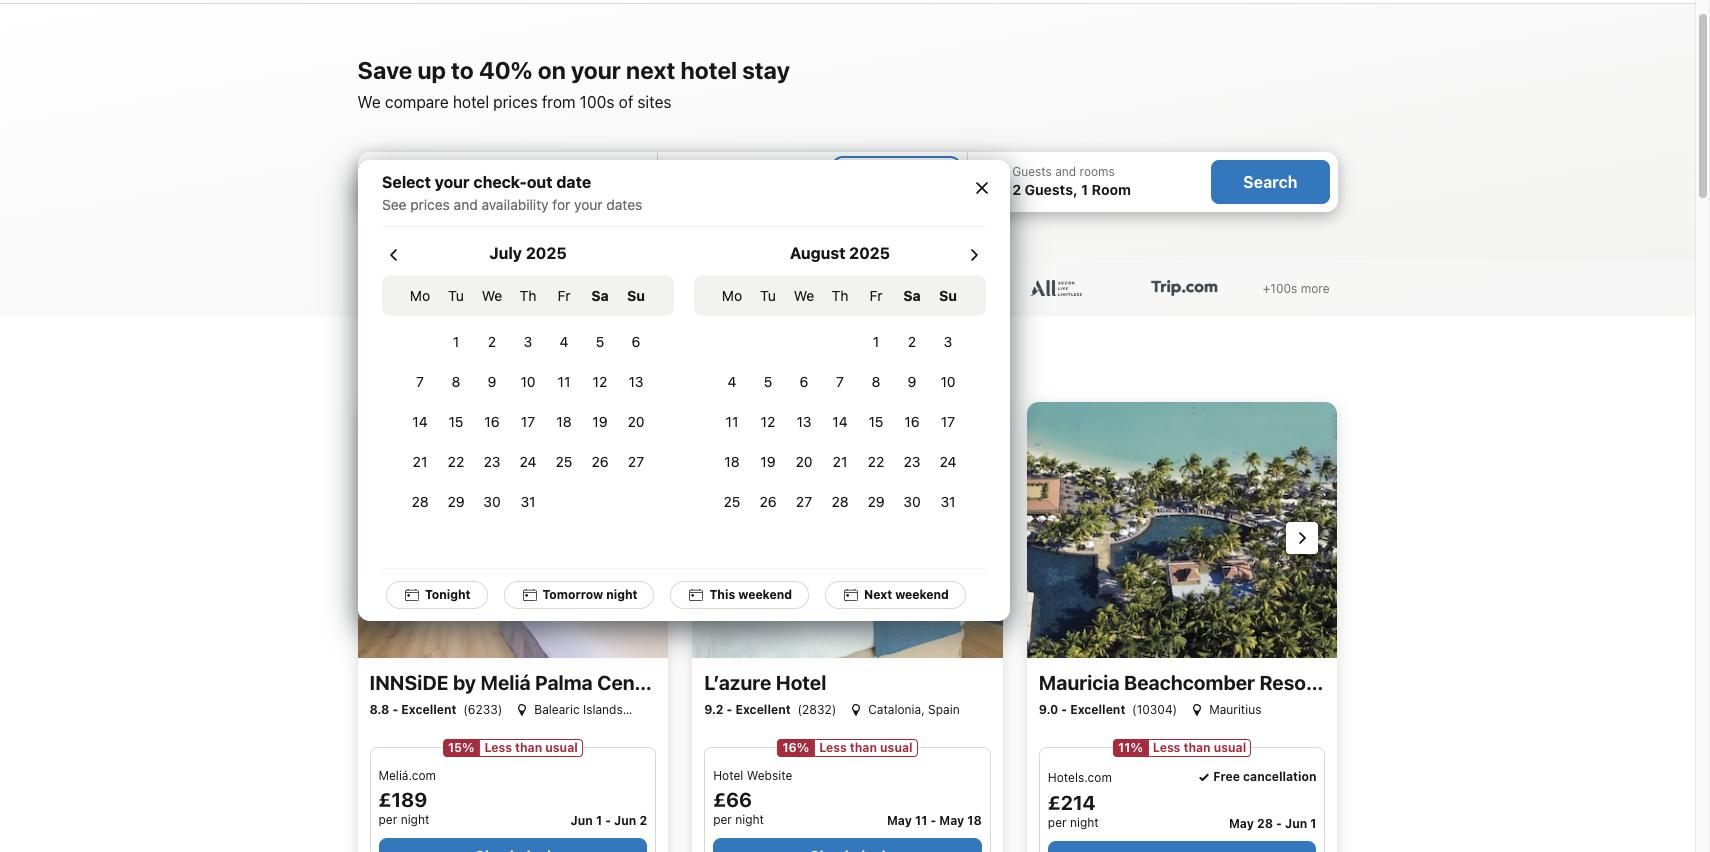

In [ ]:
# Example image URL for a web screenshot (replace with your own image)
image_url: str = "https://raw.githubusercontent.com/hcompai/hai-cookbook/445d2017fcc8a0867081ea4786c34f87ed7053eb/data/calendar_example.jpg"

# Download and open image
response = requests.get(image_url, stream=True)
image = Image.open(response.raw)

# Define task
task: str = "Book a hotel in Paris on August 3rd for 3 nights"


print(f"Task: {task}")
image.show()

## 4. Set Task and Prepare Image

In [5]:
# Resize image according to model's image processor
image_processor_config = processor.image_processor
resized_height, resized_width = smart_resize(
    image.height,
    image.width,
    factor=image_processor_config.patch_size * image_processor_config.merge_size,
    min_pixels=image_processor_config.min_pixels,
    max_pixels=image_processor_config.max_pixels,
)

processed_image: Image.Image = image.resize(size=(resized_width, resized_height), resample=Image.Resampling.LANCZOS)

# Create the prompt
messages: list[dict[str, Any]] = get_chat_messages(task, processed_image)

# Apply chat template
text_prompt = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

# Process inputs
inputs = processor(
    text=[text_prompt],
    images=[processed_image],
    padding=True,
    return_tensors="pt",
).to(model.device)

## 5. Run Inference

Because structured output is not enabled and generation is stochastic, parsing the output might fail. Thus, in production settings, we recommend using [vLLM](https://github.com/vllm-project/vllm) for:

- Faster inference performance
- Built-in structured output validation
- Reliable JSON schema compliance.

In [6]:
# Generate response
generated_ids = model.generate(**inputs, max_new_tokens=256)

# Decode output
generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
result = processor.batch_decode(generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

print("Raw output:", result)

Raw output: {"action": "click_absolute", "x": 947, "y": 338}


In [7]:
# Parse the JSON output
try:
    action = ClickAbsoluteAction.model_validate_json(result)
    print("Successfully parsed model output ✅")
except Exception as e:
    print(f"Could not parse JSON output: {e}")

Successfully parsed model output ✅


## 6. Visualize Results

Predicted action: Click on 'Book a hotel in Paris on August 3rd for 3 nights' at coordinates (947, 338)


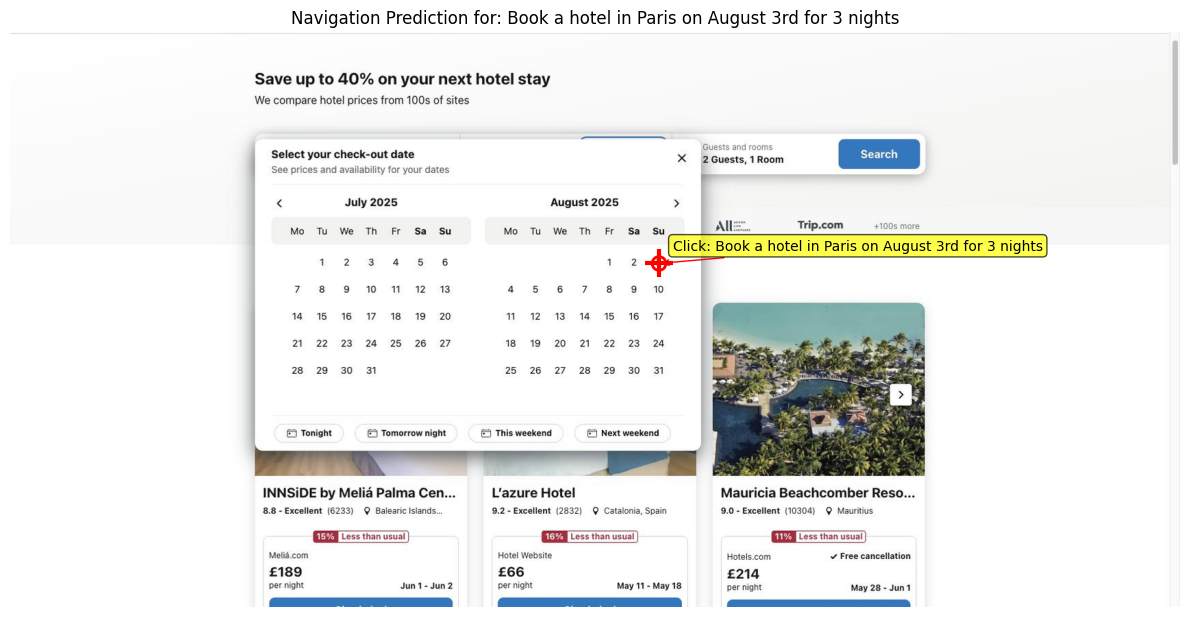

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.figure import Figure
from matplotlib.axes import Axes


def visualize_click(action: ClickAbsoluteAction, processed_img: Image.Image, task: str = "") -> tuple[Figure, Axes]:
    """
    Visualize the navigation prediction on the image.

    Args:
        navigation_output: The parsed navigation step with action coordinates
        processed_img: The processed PIL image
        task: The task description for the title

    Returns:
        Tuple of matplotlib Figure and Axes objects
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(processed_img)

    # Plot red cross at predicted coordinates
    ax.plot(action.x, action.y, "r+", markersize=20, markeredgewidth=3)

    # Add a circle around the cross for better visibility
    circle = patches.Circle((action.x, action.y), 10, linewidth=2, edgecolor="red", facecolor="none")
    ax.add_patch(circle)

    # Add text annotation
    if task:
        ax.annotate(
            f"Click: {task}",
            xy=(action.x, action.y),
            xytext=(action.x + 20, action.y - 20),
            arrowprops=dict(arrowstyle="->", color="red"),
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
            fontsize=10,
        )

    ax.set_title(f"Navigation Prediction for: {task}")
    ax.axis("off")
    plt.tight_layout()

    return fig, ax


print(f"Predicted action: Click on '{task}' at coordinates ({action.x}, {action.y})")
fig, ax = visualize_click(action, processed_image, task=task)
plt.show()

The visualization shows:
- **Red cross (⊕)**: Exact pixel coordinates where the model wants to click
- **Red circle**: Visual boundary around the target area
- **Yellow annotation**: Description of what element the model identified

The model correctly identified "August 3rd on the calendar" at coordinates (947, 338), demonstrating precise localization within the complex calendar interface.